# DRL Based Self Driving Car Control (Sensor)

## Distributional Reinforcement Learning with Quantile Regression

This notebook is DRL code for the project 'DRL based Self Driving Car Control' <br>
This version uses **Sensor data from LIDAR** as input

### Import python libraries 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import random
import datetime
import os
import time

from unityagents import UnityEnvironment

%matplotlib inline

C:\Users\Q\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Set environment path

Be sure to set `env_name` to the name of the Unity environment file you want to launch.

In [2]:
env_name = "../windows/windows" # Name of the Unity environment to launch
train_mode = True # Whether to run the environment in training or inference mode

### Start the environment
`UnityEnvironment` launches and begins communication with the environment when instantiated.

Environments contain _brains_ which are responsible for deciding the actions of their associated _agents_. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
env = UnityEnvironment(file_name=env_name)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: Brain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 373
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 5
        Vector Action descriptions: , , , , 


Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: Brain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 373
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 5
        Vector Action descriptions: , , , , 


### Examine the observation and state spaces
We can reset the environment to be provided with an initial set of observations and states for all the agents within the environment. In ML-Agents, _states_ refer to a vector of variables corresponding to relevant aspects of the environment for an agent. Likewise, _observations_ refer to a set of relevant pixel-wise visuals for an agent.

Sensor data (LIDAR): 
[  1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   0.9755246    0.91600198   0.86357307   0.81705666   0.77551937
   0.73821479   0.70453942   0.67399871   0.64618438   0.62075633
   0.59742886   0.57596022   0.5561446    0.53780544   0.52079082
   0.50496876   0.49022466   0.47645816   0.46358114   0.45151567
   0.44019303   0.42955208   0.41953811   0.41010255   0.40120158
   0.39279586   0.38485005   0.37733197   0.37021253   0.36346549
   0.35706681   0.35099453   0.34522879   0.33975118   0.33454502
   0.32959491   0.32488668   0.32040724   0.31614468   0.31208783
   0.30822647   0.30455115   0.30105308   0.29772413   0.29455668
   0.29154381   0.288679     0.28595623   0.28336981   0.2809146
   0.27858567   0.27637851   0.27428898   0.27231315   0.27044734
   0.26868826   0.26703268   0.26547778   0.26402083   0.26265934
   0.26139107

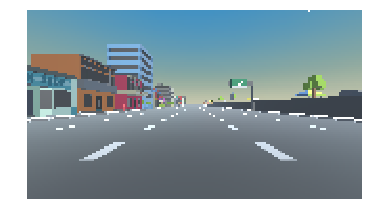

In [4]:
# Reset the environment
env_info = env.reset(train_mode=train_mode)[default_brain]

# Examine the state space for the default brain
print("Sensor data (LIDAR): \n{}".format(env_info.vector_observations[0]))

# Examine the observation space for the default brain
Num_obs = len(env_info.visual_observations)

print("Image data (Front Camera): \n{}")
if Num_obs > 1:
    f, axarr = plt.subplots(1, Num_obs, figsize=(20,10))
    for i, observation in enumerate(env_info.visual_observations):
        if observation.shape[3] == 3:
            axarr[i].imshow(observation[0,:,:,:])
            axarr[i].axis('off')
        else:
            axarr[i].imshow(observation[0,:,:,0])
            axarr[i].axis('off')
else:
    f, axarr = plt.subplots(1, Num_obs)
    for i, observation in enumerate(env_info.visual_observations):
        if observation.shape[3] == 3:
            axarr.imshow(observation[0,:,:,:])
            axarr.axis('off')
        else:
            axarr.imshow(observation[0,:,:,0])
            axarr.axis('off')

### Set Parameters

In [5]:
algorithm = 'QR-DQN'
Num_action = brain.vector_action_space_size

# QR-DQN Parameter
Num_quantile = 51
        
# parameter for DQN
Num_replay_memory = 100000
Num_start_training = 50000
Num_training = 1000000
Num_update = 10000
Num_batch = 32
Num_test = 100000
Num_skipFrame = 4
Num_stackFrame = 4
Num_colorChannel = 1

Epsilon = 1.0
Final_epsilon = 0.1
Gamma = 0.99
Learning_rate = 0.00005

# Parameter for LSTM
Num_dataSize = 366
Num_cellState = 512

# Parameters for network
img_size = 80
sensor_size = 360

first_dense  = [Num_cellState, 512]
second_dense = [first_dense[1], Num_action * Num_quantile]

# Path of the network model
load_path = '../saved_networks/2018-09-12_0_19_QR-DQN_sensor/model.ckpt'

# Parameters for session
Num_plot_episode = 5
Num_step_save = 50000

GPU_fraction = 0.4

### Functions for Networks

In [6]:
# Initialize weights and bias
def weight_variable(shape):
    return tf.Variable(xavier_initializer(shape))

def bias_variable(shape):
	return tf.Variable(xavier_initializer(shape))

# Xavier Weights initializer
def xavier_initializer(shape):
	dim_sum = np.sum(shape)
	if len(shape) == 1:
		dim_sum += 1
	bound = np.sqrt(2.0 / dim_sum)
	return tf.random_uniform(shape, minval=-bound, maxval=bound)

# Assign network variables to target network
def assign_network_to_target():
	# Get trainable variables
	trainable_variables = tf.trainable_variables()
	# network lstm variables
	trainable_variables_network = [var for var in trainable_variables if var.name.startswith('network')]

	# target lstm variables
	trainable_variables_target = [var for var in trainable_variables if var.name.startswith('target')]

    # assign network variables to target network
	for i in range(len(trainable_variables_network)):
		sess.run(tf.assign(trainable_variables_target[i], trainable_variables_network[i]))

# Code for tensorboard
def setup_summary():
    episode_speed      = tf.Variable(0.)
    episode_overtake   = tf.Variable(0.)
    episode_lanechange = tf.Variable(0.)

    tf.summary.scalar('Average_Speed/' + str(Num_plot_episode) + 'episodes', episode_speed)
    tf.summary.scalar('Average_overtake/' + str(Num_plot_episode) + 'episodes', episode_overtake)
    tf.summary.scalar('Average_lanechange/' + str(Num_plot_episode) + 'episodes', episode_lanechange)

    summary_vars = [episode_speed, episode_overtake, episode_lanechange]
    summary_placeholders = [tf.placeholder(tf.float32) for _ in range(len(summary_vars))]
    update_ops = [summary_vars[i].assign(summary_placeholders[i]) for i in range(len(summary_vars))]
    summary_op = tf.summary.merge_all()
    return summary_placeholders, update_ops, summary_op

### Network

In [7]:
tf.reset_default_graph()

x_sensor = tf.placeholder(tf.float32, shape = [None, Num_stackFrame, Num_dataSize])
x_unstack = tf.unstack(x_sensor, axis = 1)

with tf.variable_scope('network'):

    # LSTM cell
    cell = tf.contrib.rnn.BasicLSTMCell(num_units = Num_cellState)            
    rnn_out, rnn_state = tf.nn.static_rnn(inputs = x_unstack, cell = cell, dtype = tf.float32)
    
    # Densely connect layer variables
    w_fc1 = weight_variable(first_dense)
    b_fc1 = bias_variable([first_dense[1]])

    w_fc2 = weight_variable(second_dense)
    b_fc2 = bias_variable([second_dense[1]])
    
    
# Network
rnn_out = rnn_out[-1]

h_fc1 = tf.nn.relu(tf.matmul(rnn_out, w_fc1)+b_fc1)

# Get Q value for each action
logits = tf.matmul(h_fc1, w_fc2) + b_fc2
logits_reshape = tf.reshape(logits, [-1, Num_action, Num_quantile])
Q_action = tf.reduce_sum(tf.multiply(1/Num_quantile, logits_reshape), axis = 2)

with tf.variable_scope('target'):
    # LSTM cell
    cell_target = tf.contrib.rnn.BasicLSTMCell(num_units = Num_cellState)            
    rnn_out_target, rnn_state_target = tf.nn.static_rnn(inputs = x_unstack, cell = cell_target, dtype = tf.float32)

    # Densely connect layer variables target
    w_fc1_target = weight_variable(first_dense)
    b_fc1_target = bias_variable([first_dense[1]])

    w_fc2_target = weight_variable(second_dense)
    b_fc2_target = bias_variable([second_dense[1]])
    
# Target Network
rnn_out_target = rnn_out_target[-1]

h_fc1_target  = tf.nn.relu(tf.matmul(rnn_out_target, w_fc1_target)+b_fc1_target)

# Get Q value for each action
logits_target = tf.matmul(h_fc1_target, w_fc2_target) + b_fc2_target
logits_reshape_target = tf.reshape(logits_target, [-1, Num_action, Num_quantile])
Q_action_target = tf.reduce_sum(tf.multiply(1/Num_quantile, logits_reshape_target), axis = 2)

### Loss and Train

In [8]:
# Loss function and Train
theta_loss = tf.placeholder(tf.float32, shape = [None, Num_quantile])
action_binary_loss = tf.placeholder(tf.float32, shape = [None, Num_action, Num_quantile])

# Get valid logits 
logit_valid = tf.multiply(logits_reshape, action_binary_loss)
logit_valid_nonzero = tf.reduce_sum(logit_valid, axis = 1)

# Stack i and j
theta_loss_tile = tf.tile(tf.expand_dims(theta_loss, axis=2), [1, 1, Num_quantile])
logit_valid_tile = tf.tile(tf.expand_dims(logit_valid_nonzero, axis=1), [1, Num_quantile, 1])

error_loss = theta_loss_tile - logit_valid_tile

# Get Huber loss
Huber_loss = tf.losses.huber_loss(theta_loss_tile, logit_valid_tile, reduction = tf.losses.Reduction.NONE)

# Get tau
min_tau = 1/(2*Num_quantile)
max_tau = (2*(Num_quantile-1)+3)/(2*Num_quantile)
tau = tf.reshape (tf.range(min_tau, max_tau, 1/Num_quantile), [1, Num_quantile])
inv_tau = 1.0 - tau 

# Get Loss
Loss = tf.where(tf.less(error_loss, 0.0), inv_tau * Huber_loss, tau * Huber_loss)
Loss = tf.reduce_mean(tf.reduce_sum(tf.reduce_mean(Loss, axis = 2), axis = 1))

train_step = tf.train.AdamOptimizer(learning_rate = Learning_rate, epsilon = 1e-02/Num_batch).minimize(Loss)

### Config

In [9]:
## Initialize variables
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = GPU_fraction

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

### Training or Inference

In [10]:
# Load the file if the saved file exists
saver = tf.train.Saver()

# check_save = 1
check_save = input('Inference? / Training?(1=Inference/2=Training): ')

if check_save == '1':
    # Directly start inference
    Num_start_training = 0
    Num_training = 0
    
    # Restore variables from disk.
    saver.restore(sess, load_path)
    print("Model restored.")

# date - hour - minute of training time
date_time = str(datetime.date.today()) + '_' + str(datetime.datetime.now().hour) + '_' + str(datetime.datetime.now().minute)

# Make folder for save data
os.makedirs('../saved_networks/' + date_time + '_' + algorithm + '_sensor')

# Summary for tensorboard
summary_placeholders, update_ops, summary_op = setup_summary()
summary_writer = tf.summary.FileWriter('../saved_networks/' + date_time + '_' + algorithm + '_sensor', sess.graph)

Inference? / Training?(1=Inference/2=Training): 2


### Functions for Training

In [11]:
# Initialize input 
def state_initialization(env_info):    
    state = env_info.vector_observations[0][:-7]

    state_set = []

    for i in range(Num_skipFrame * Num_stackFrame):
        state_set.append(state)
    
    # Stack the frame according to the number of skipping and stacking frames using observation set
    state_stack = np.zeros((Num_stackFrame, Num_dataSize))
    for stack_frame in range(Num_stackFrame):
        state_stack[(Num_stackFrame - 1) - stack_frame, :] = state_set[-1 - (Num_skipFrame * stack_frame)]

    state_stack = np.uint8(state_stack)

    return state_stack, state_set

# Resize input information 
def resize_state(env_info, state_set):
    state = env_info.vector_observations[0][:-7]

    # Add state to the state_set
    state_set.append(state)
    
    # Stack the frame according to the number of skipping and stacking frames using observation set
    state_stack = np.zeros((Num_stackFrame, Num_dataSize))
    for stack_frame in range(Num_stackFrame):
        state_stack[(Num_stackFrame - 1) - stack_frame, :] = state_set[-1 - (Num_skipFrame * stack_frame)]
        
    del state_set[0]

    state_stack = np.uint8(state_stack)
    
    return state_stack, state_set

# Get progress according to the number of steps
def get_progress(step, Epsilon):
    if step <= Num_start_training:
        # Observation
        progress = 'Observing'
        train_mode = True
        Epsilon = 1
    elif step <= Num_start_training + Num_training:
        # Training
        progress = 'Training'
        train_mode = True
        
        # Decrease the epsilon value
        if Epsilon > Final_epsilon:
            Epsilon -= 1.0/Num_training
    elif step < Num_start_training + Num_training + Num_test:
        # Testing
        progress = 'Testing'
        train_mode = False
        Epsilon = 0
    else:
        # Finished
        progress = 'Finished'
        train_mode = False
        Epsilon = 0
        
    return progress, train_mode, Epsilon 

# Select action according to the progress of training
def select_action(progress, sess, observation_stack, Epsilon):
    if progress == "Observing":
        # Random action 
        Q_value = 0
        action = np.zeros([Num_action])
        action[random.randint(0, Num_action - 1)] = 1.0
    elif progress == "Training":
        # if random value(0-1) is smaller than Epsilon, action is random. 
        # Otherwise, action is the one which has the max Q value
        if random.random() < Epsilon:
            Q_value = 0
            action = np.zeros([Num_action])
            action[random.randint(0, Num_action - 1)] = 1
        else:
            Q_value = Q_action.eval(feed_dict={x_sensor: [state_stack]})
            action = np.zeros([Num_action])
            action[np.argmax(Q_value)] = 1
    else:
        # Max Q action 
        Q_value = Q_action.eval(feed_dict={x_sensor: [state_stack]})
        action = np.zeros([Num_action])
        action[np.argmax(Q_value)] = 1
        
    return action, Q_value

def train(Replay_memory, sess, step):
    # Select minibatch
    minibatch =  random.sample(Replay_memory, Num_batch)

    # Save the each batch data
    state_batch      = [batch[0] for batch in minibatch]
    action_batch     = [batch[1] for batch in minibatch]
    reward_batch     = [batch[2] for batch in minibatch]
    state_next_batch = [batch[3] for batch in minibatch]
    terminal_batch 	 = [batch[4] for batch in minibatch]

    # Update target network according to the Num_update value
    if step % Num_update == 0:
        assign_network_to_target()
    
    
    # Get Target
    Q_batch = Q_action.eval(feed_dict = {x_sensor: state_next_batch})
    theta_batch = logits_reshape_target.eval(feed_dict = {x_sensor: state_next_batch})

    theta_target = []

    for i in range(len(minibatch)):
        theta_target.append([])
        for j in range(Num_quantile):
            if terminal_batch[i] == True:
                theta_target[i].append(reward_batch[i])
            else:
                theta_target[i].append(reward_batch[i] + Gamma * theta_batch[i, np.argmax(Q_batch[i]), j])

    # Calculate action binary
    action_binary = np.zeros([Num_batch, Num_action, Num_quantile])

    for i in range(len(action_batch)):
        action_batch_max = np.argmax(action_batch[i])
        action_binary[i, action_batch_max, :] = 1

    _, loss = sess.run([train_step, Loss],feed_dict = {x_sensor: state_batch,
                                                       theta_loss: theta_target, 
                                                       action_binary_loss: action_binary})

# Experience Replay 
def Experience_Replay(progress, Replay_memory, state_stack, action, reward, next_state_stack, terminal):
    if progress != 'Testing':
        # If length of replay memeory is more than the setting value then remove the first one
        if len(Replay_memory) > Num_replay_memory:
            del Replay_memory[0]

        # Save experience to the Replay memory
        Replay_memory.append([state_stack, action, reward, next_state_stack, terminal])
    else:
        # Empty the replay memory if testing
        Replay_memory = []
    
    return Replay_memory

### Initialize Variables

In [12]:
# Initial parameters
Replay_memory = []

step = 1
score = 0
score_board = 0

episode = 0
step_per_episode = 0

speed_list = []
overtake_list = []
lanechange_list = []

train_mode = True
env_info = env.reset(train_mode=train_mode)[default_brain]

state_stack, state_set = state_initialization(env_info)

### Training

In [13]:
check_plot = 0

# Training & Testing
while True:
   
    # Get Progress, train mode
    progress, train_mode, Epsilon  = get_progress(step, Epsilon)
    
    # Select Actions 
    action, Q_value = select_action(progress, sess, state_stack, Epsilon)
    action_in = [np.argmax(action)]
    
    # Get information for plotting
    vehicle_speed  = 100 * env_info.vector_observations[0][-8]
    num_overtake   = env_info.vector_observations[0][-7]
    num_lanechange = env_info.vector_observations[0][-6]
    
    # Get information for update
    env_info = env.step(action_in)[default_brain]

    next_state_stack, state_set = resize_state(env_info, state_set) 
    reward = env_info.rewards[0]
    terminal = env_info.local_done[0]
    
    if progress == 'Training':
        # Train!! 
        train(Replay_memory, sess, step)

        # Save the variables to disk.
        if step == Num_start_training + Num_training:
            save_path = saver.save(sess, '../saved_networks/' + date_time + '_' + algorithm + '_sensor' + "/model.ckpt")
            print("Model saved in file: %s" % save_path)
    
    # If progress is finished -> close! 
    if progress == 'Finished':
        print('Finished!!')
        env.close()
        break
        
    Replay_memory = Experience_Replay(progress, 
                                      Replay_memory, 
                                      state_stack,
                                      action, 
                                      reward, 
                                      next_state_stack,
                                      terminal)
    
    # Update information
    step += 1
    score += reward
    step_per_episode += 1
    
    state_stack = next_state_stack
    
    # Update tensorboard
    if progress != 'Observing':
        speed_list.append(vehicle_speed)
        
        if episode % Num_plot_episode == 0 and check_plot == 1 and episode != 0:
            avg_speed      = sum(speed_list) / len(speed_list)
            avg_overtake   = sum(overtake_list) / len(overtake_list)
            avg_lanechange = sum(lanechange_list) / len(lanechange_list)
            
            tensorboard_info = [avg_speed, avg_overtake, avg_lanechange]
            for i in range(len(tensorboard_info)):
                sess.run(update_ops[i], feed_dict = {summary_placeholders[i]: float(tensorboard_info[i])})
            summary_str = sess.run(summary_op)
            summary_writer.add_summary(summary_str, step)
            score_board = 0
            
            speed_list = []
            overtake_list = []
            lanechange_list = []

            check_plot = 0
            
    # If terminal is True
    if terminal == True:
        # Print informations
        print('step: ' + str(step) + ' / '  + 'episode: ' + str(episode) + ' / ' + 'progress: ' + progress  + ' / ' + 'epsilon: ' + str(Epsilon)  +' / ' + 'score: ' + str(score))

        check_plot = 1

        if progress != 'Observing':
            episode += 1
            
            score_board += score
            overtake_list.append(num_overtake)
            lanechange_list.append(num_lanechange)
        
            
        score = 0
        step_per_episode = 0

        # Initialize game state
        env_info = env.reset(train_mode=train_mode)[default_brain]
        state_stack, state_set = state_initialization(env_info)

        



step: 4518 / episode: 0 / progress: Observing / epsilon: 1 / score: 1774.4308096468449
step: 9223 / episode: 0 / progress: Observing / epsilon: 1 / score: 1561.15655464679
step: 10493 / episode: 0 / progress: Observing / epsilon: 1 / score: 468.3725060224533
step: 15296 / episode: 0 / progress: Observing / epsilon: 1 / score: 1452.4769280925393
step: 18728 / episode: 0 / progress: Observing / epsilon: 1 / score: 984.6319274827838
step: 23451 / episode: 0 / progress: Observing / epsilon: 1 / score: 1527.9668709635735
step: 24691 / episode: 0 / progress: Observing / epsilon: 1 / score: 298.7393363714218
step: 29568 / episode: 0 / progress: Observing / epsilon: 1 / score: 1377.9948867112398
step: 32670 / episode: 0 / progress: Observing / epsilon: 1 / score: 1182.637726791203
step: 37327 / episode: 0 / progress: Observing / epsilon: 1 / score: 1614.9977910667658
step: 41952 / episode: 0 / progress: Observing / epsilon: 1 / score: 1642.6178614646196
step: 46829 / episode: 0 / progress: Obs

step: 254853 / episode: 67 / progress: Training / epsilon: 0.7951479999941093 / score: 89.35527832061052
step: 255946 / episode: 68 / progress: Training / epsilon: 0.7940549999940779 / score: 469.6424149721861
step: 256808 / episode: 69 / progress: Training / epsilon: 0.7931929999940531 / score: 522.3373877629638
step: 257645 / episode: 70 / progress: Training / epsilon: 0.7923559999940291 / score: 518.8961923271418
step: 261904 / episode: 71 / progress: Training / epsilon: 0.7880969999939066 / score: 2056.3571939617395
step: 265333 / episode: 72 / progress: Training / epsilon: 0.784667999993808 / score: 1655.9587793946266
step: 269950 / episode: 73 / progress: Training / epsilon: 0.7800509999936752 / score: 1667.5962187573314
step: 273970 / episode: 74 / progress: Training / epsilon: 0.7760309999935596 / score: 2326.936546690762
step: 275725 / episode: 75 / progress: Training / epsilon: 0.7742759999935092 / score: 936.5852511823177
step: 280125 / episode: 76 / progress: Training / eps

step: 474913 / episode: 145 / progress: Training / epsilon: 0.5750879999877814 / score: 1199.9221104457974
step: 476084 / episode: 146 / progress: Training / epsilon: 0.5739169999877477 / score: 642.1448692083359
step: 478771 / episode: 147 / progress: Training / epsilon: 0.5712299999876704 / score: 1713.757760323584
step: 479216 / episode: 148 / progress: Training / epsilon: 0.5707849999876576 / score: 317.1966537386179
step: 483310 / episode: 149 / progress: Training / epsilon: 0.5666909999875399 / score: 2256.2800573706627
step: 487050 / episode: 150 / progress: Training / epsilon: 0.5629509999874324 / score: 2644.7772723138332
step: 489057 / episode: 151 / progress: Training / epsilon: 0.5609439999873747 / score: 972.2706998735666
step: 493162 / episode: 152 / progress: Training / epsilon: 0.5568389999872566 / score: 2241.3108214214444
step: 495461 / episode: 153 / progress: Training / epsilon: 0.5545399999871905 / score: 1771.195482134819
step: 499486 / episode: 154 / progress: Tr

step: 677328 / episode: 222 / progress: Training / epsilon: 0.3726729999890289 / score: 667.5729990974069
step: 681031 / episode: 223 / progress: Training / epsilon: 0.368969999989128 / score: 2683.8321270495653
step: 685294 / episode: 224 / progress: Training / epsilon: 0.36470699998924205 / score: 2073.8010083585978
step: 687082 / episode: 225 / progress: Training / epsilon: 0.3629189999892899 / score: 1305.220741033554
step: 688652 / episode: 226 / progress: Training / epsilon: 0.3613489999893319 / score: 955.0421020537615
step: 691829 / episode: 227 / progress: Training / epsilon: 0.3581719999894169 / score: 2083.1251241862774
step: 695243 / episode: 228 / progress: Training / epsilon: 0.35475799998950824 / score: 3019.53120251745
step: 698392 / episode: 229 / progress: Training / epsilon: 0.3516089999895925 / score: 2140.094640098512
step: 701296 / episode: 230 / progress: Training / epsilon: 0.3487049999896702 / score: 2048.019129373133
step: 704424 / episode: 231 / progress: Tra

step: 880383 / episode: 299 / progress: Training / epsilon: 0.16961799999223068 / score: 2579.2629097625613
step: 880859 / episode: 300 / progress: Training / epsilon: 0.1691419999922302 / score: 376.78755339980125
step: 883491 / episode: 301 / progress: Training / epsilon: 0.16650999999222757 / score: 2498.6213083416224
step: 887305 / episode: 302 / progress: Training / epsilon: 0.16269599999222376 / score: 2608.727791339159
step: 888609 / episode: 303 / progress: Training / epsilon: 0.16139199999222245 / score: 1047.116237707436
step: 890394 / episode: 304 / progress: Training / epsilon: 0.15960699999222067 / score: 993.8774575665593
step: 892512 / episode: 305 / progress: Training / epsilon: 0.15748899999221855 / score: 1258.0361316800117
step: 892997 / episode: 306 / progress: Training / epsilon: 0.15700399999221806 / score: 469.32500034570694
step: 897075 / episode: 307 / progress: Training / epsilon: 0.15292599999221398 / score: 2274.8281207084656
step: 900387 / episode: 308 / pr

step: 1092190 / episode: 377 / progress: Testing / epsilon: 0 / score: 1150.8639184311032
step: 1095671 / episode: 378 / progress: Testing / epsilon: 0 / score: 2993.7196144387126
step: 1099352 / episode: 379 / progress: Testing / epsilon: 0 / score: 1576.7600041627884
step: 1100188 / episode: 380 / progress: Testing / epsilon: 0 / score: 832.7000004649162
step: 1103941 / episode: 381 / progress: Testing / epsilon: 0 / score: 2669.217904523015
step: 1106694 / episode: 382 / progress: Testing / epsilon: 0 / score: 2737.1397224366665
step: 1110138 / episode: 383 / progress: Testing / epsilon: 0 / score: 3030.0351167470217
step: 1112604 / episode: 384 / progress: Testing / epsilon: 0 / score: 2154.855725966394
step: 1116357 / episode: 385 / progress: Testing / epsilon: 0 / score: 2707.9528041109443
step: 1119978 / episode: 386 / progress: Testing / epsilon: 0 / score: 2796.0446490496397
step: 1123456 / episode: 387 / progress: Testing / epsilon: 0 / score: 3006.8735202103853
step: 1123858

In [14]:
env.close()